# Introduction to Trodes data import into `nelpy` 

<div class="alert alert-info">
<b>What is Trodes and what is supported by nelpy? </b>
</div>

[Trodes](http://spikegadgets.com/software/trodes.html) is
> an open source, cross-platform software suite for neuroscience data acquisition and experimental control.

Here, we enable importing some data from Trodes post recording from the Trodes data-type saved .rec file directly into `nelpy`. The code for this is cleverly hidden under the io directory within `nelpy` in a file named trodes.py. In particular the data from the .recs that can be imported into `nelpy` include the following:
- Wide-band (or subsampled) ephys waveforms
- Auxiliary channels (as of right now only digital inputs and outputs are importable)
- Spike waveform snippits as determined within Trodes

Support is currently being expanded to support:
- Video frames and timestamp coordination
- Other auxiliary channels such as analog inputs/outputs, accelerometer data
- Other stuff (exciting and ambiguous!)

<br><br><div class="alert alert-info">
<b>How does it work?</b>
</div>
The `nelpy` import code relies heavily on modified versions of exportLFP, exportdio, exportspikes, etc. (essentially the Export functionality provided in the Trodes C++ code but I have modified them to take in added parameters). As such, my modifications to the Trodes export functions have been provided under the [resources folder on the `nelpy` github](https://github.com/eackermann/nelpy/tree/feature/TrodesImport/resources). BUT we will move away from this and just have pure Python implementations soon!

<br><br><div class="alert alert-info">
<b>How do I set it up?</b>
</div>
<b> INSTRUCTIONS GO HERE!</b>

In [1]:
#imports
import numpy as np
from scipy import interpolate
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import sys
import os

import nelpy as nel  # recommended import for nelpy
import nelpy.plotting as npl  # recommended import for the nelpy plotting library
import nelpy.io.trodes as neltro

In [2]:
#Shay's plot settings
%matplotlib inline
npl.setup()
npl.set_palette(npl.colors.cows)
npl.setup(font='Universalis ADF Cd Std', font_scale=2, palette=npl.colors.cows, style='white',\
         rc=({'figure.figsize': (12, 6), 'font.size': 18, 'axes.labelsize': 25, \
             'axes.titlesize':33, 'legend.fontsize': 20, 'ytick.labelsize': 20, 'xtick.labelsize': 20}))

# Importing Wide-Band LFP data

## Get tetrodes and channels

In [2]:
#Linux
tetrodes, channels = neltro.load_tetrode_channel_nums("/media/shayok/3TBData/Data/JChuTru/Install/Experiments/unthethered/06-30-2017/install_06-30-2017_00_09_56_merge_sd11.rec",\
                                 verbose = True)

Tetrodes:  [ 1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5  6  6  6  6  7
  7  7  7  8  8  8  8  9  9  9  9 10 10 10 10 11 11 11 11 12 12 12 12 13 13
 13 13 14 14 14 14 15 15 15 15 16 16 16 16 17 17 17 17 18 18 18 18 19 19 19
 19 20 20 20 20]
Channels:  [1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1
 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2
 3 4 1 2 3 4]


In [3]:
#Windows (It's the same exact command cross platforms just gotta specify file location)
tetrodes, channels = neltro.load_tetrode_channel_nums("C:/Users/kemere_lab/Desktop/ShayWillDeleteThisFile/Kant_control_stimulation_single_channel1_5_27.rec",\
                                 verbose = True)

Tetrodes:  [1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 7 8 8 8 8]
Channels:  [1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4]


<div class="alert alert-info">
Above is not necessary unless you're loading up everything. On the other hand, if we wanted to disable particular channels from being loaded (e.g. I don't care about Tetrode 10 because it's in a different area of the brain that I'm using as reference or I don't care about tetrode 11 because it's lost, I can disable it like below), that is when this function comes handy as in the example below. 
</div>

In [3]:
#Linux
tetrodes, channels = neltro.load_tetrode_channel_nums("/media/shayok/3TBData/Data/JChuTru/Install/Experiments/unthethered/06-30-2017/install_06-30-2017_00_09_56_merge_sd11.rec",\
                                                      disable_tetrodes = [10,11],verbose = True)

Disabling Tetrode 10 
Disabling Tetrode 11 
Tetrodes:  [ 1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5  6  6  6  6  7
  7  7  7  8  8  8  8  9  9  9  9 12 12 12 12 13 13 13 13 14 14 14 14 15 15
 15 15 16 16 16 16 17 17 17 17 18 18 18 18 19 19 19 19 20 20 20 20]
Channels:  [1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1
 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4]


In [5]:
#Windows
tetrodes, channels = neltro.load_tetrode_channel_nums("C:/Users/kemere_lab/Desktop/ShayWillDeleteThisFile/Kant_control_stimulation_single_channel1_5_27.rec",\
                                                      disable_tetrodes = [2,8],verbose = True)

Disabling Tetrode 2 
Disabling Tetrode 8 
Tetrodes:  [1 1 1 1 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 7]
Channels:  [1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4]


<br><div class="alert alert-info">
Also, we can disable specific channels that we don't want. E.g. say tetrode 3 accidentally has two of it's channels messed up for some reason so we can disable particular channels from being loaded up. In the example below we remove tetrode 3 channels 2 and 4 and tetrode 4 channel 1.
</div>

In [4]:
#Linux
tetrodes, channels = neltro.load_tetrode_channel_nums("/media/shayok/3TBData/Data/JChuTru/Install/Experiments/unthethered/06-30-2017/install_06-30-2017_00_09_56_merge_sd11.rec",\
                                                      disable_tetrodes = [3,3,4], disable_channels=[2,4,1],\
                                                      verbose = True)

Disabling Tetrode 3 | Channel(s) [2 4]
Disabling Tetrode 4 | Channel(s) [1]
Tetrodes:  [ 1  1  1  1  2  2  2  2  3  3  4  4  4  5  5  5  5  6  6  6  6  7  7  7  7
  8  8  8  8  9  9  9  9 10 10 10 10 11 11 11 11 12 12 12 12 13 13 13 13 14
 14 14 14 15 15 15 15 16 16 16 16 17 17 17 17 18 18 18 18 19 19 19 19 20 20
 20 20]
Channels:  [1 2 3 4 1 2 3 4 1 3 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4
 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1
 2 3 4]


In [6]:
#Windows 
tetrodes, channels = neltro.load_tetrode_channel_nums("C:/Users/kemere_lab/Desktop/ShayWillDeleteThisFile/Kant_control_stimulation_single_channel1_5_27.rec",\
                                                      disable_tetrodes = [2,8],disable_channels=[2,4],verbose = True)

Disabling Tetrode 2 | Channel(s) [2]
Disabling Tetrode 8 | Channel(s) [4]
Tetrodes:  [1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 7 8 8 8]
Channels:  [1 2 3 4 1 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3]


<br><div class="alert alert-success">
In conclusion, this function here should be used as a helper if you're trying to load up a large subset of the tetrodes and channels or else it's just easier typing them in as inputs to the tetrode and channel keyword arguments in loading functions shown in the subsection below.
</div>

## Begin imports into AnalogSignalArrays

<br><div class="alert alert-info">
Quick example of how to load up all channels from all tetrodes from a recording session.
</div>

In [4]:
#Linux
tetrodes, channels = neltro.load_tetrode_channel_nums("/home/shayok/Documents/Code/RippleDetectionAnalysis/TingData/Kant_stimulation_two_channel14_5_27.rec")
asa = neltro.load_wideband_lfp_rec("/home/shayok/Documents/Code/RippleDetectionAnalysis/TingData/Kant_stimulation_two_channel14_5_27.rec",\
                      "/home/shayok/Documents/Code/trodes/", tetrode = tetrodes, channel=channels)
asa

/home/shayok/Documents/Code/nelpy/nelpy/io/trodes.py:478: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


<AnalogSignalArray at 0x7f23b37f7d30: 32 signals> for a total of 1:21:996 minutes

In [6]:
asa._ydata.shape

(32, 2459880)

In [7]:
asa.fs

30000.0

In [ ]:
scipy.io.savemat()

In [4]:
#Windows just double checking it works
tetrodes, _ = neltro.load_tetrode_channel_nums("C:/Users/kemere_lab/Desktop/ShayWillDeleteThisFile/Kant_control_stimulation_single_channel1_5_27.rec")
asa = neltro.load_wideband_lfp_rec("C:/Users/kemere_lab/Desktop/ShayWillDeleteThisFile/Kant_control_stimulation_single_channel1_5_27.rec",\
                      "C:/Users/kemere_lab/Documents/Code/trodes/", tetrode = tetrodes, everything = True, verbose = True)
asa

C:/Users/kemere_lab/Documents/Code/trodes/bin/win32/exportLFP.exe -rec "C:/Users/kemere_lab/Desktop/ShayWillDeleteThisFile/Kant_control_stimulation_single_channel1_5_27.rec" -userefs "0" -lowpass -1 -highpass -1 -everything "1"
*****************Loading LFP Timestamps*****************
b'<Start settings>\n'
b'Description: LFP timestamps\n'
b'Byte_order: little endian\n'
b'Original_file: Kant_control_stimulation_single_channel1_5_27.rec\n'
b'Clock rate: 30000\n'
b'Decimation: 1\n'
b'Time_offset: 0\n'
b'Fields: <time uint32>\n'
Current file position 220
Done
*****************Loading LFP Data*****************
b'<Start settings>\n'
b'Description: LFP data for one channel\n'
b'Byte_order: little endian\n'
b'Original_file: Kant_control_stimulation_single_channel1_5_27.rec\n'
b'nTrode_ID: 1\n'
b'nTrode_channel: 1\n'
b'Clock rate: 30000\n'
b'Voltage_scaling: 0.195\n'
b'Decimation: 1\n'
b'First_timestamp: 3034980\n'
b'Reference: off\n'
b'Low_pass_filter: 6000\n'
b'Fields: <voltage int16>\n'
Curre

c:\users\kemere_lab\documents\code\nelpy\nelpy\core\_analogsignalarray.py:267: UserWarning: No support given. Creating support from time and sampling rate, fs!


*****************Loading LFP Timestamps*****************
b'<Start settings>\n'
b'Description: LFP timestamps\n'
b'Byte_order: little endian\n'
b'Original_file: Kant_control_stimulation_single_channel1_5_27.rec\n'
b'Clock rate: 30000\n'
b'Decimation: 1\n'
b'Time_offset: 0\n'
b'Fields: <time uint32>\n'
Current file position 220
Done
*****************Loading LFP Data*****************
b'<Start settings>\n'
b'Description: LFP data for one channel\n'
b'Byte_order: little endian\n'
b'Original_file: Kant_control_stimulation_single_channel1_5_27.rec\n'
b'nTrode_ID: 2\n'
b'nTrode_channel: 1\n'
b'Clock rate: 30000\n'
b'Voltage_scaling: 0.195\n'
b'Decimation: 1\n'
b'First_timestamp: 3034980\n'
b'Reference: off\n'
b'Low_pass_filter: 6000\n'
b'Fields: <voltage int16>\n'
Current file position 333
Done
*****************Loading LFP Data*****************
b'<Start settings>\n'
b'Description: LFP data for one channel\n'
b'Byte_order: little endian\n'
b'Original_file: Kant_control_stimulation_single_channe

[<AnalogSignalArray at 0x243eac342b0: 4 signals> for a total of 41.442 seconds,
 <AnalogSignalArray at 0x243eae7c2e8: 4 signals> for a total of 41.442 seconds,
 <AnalogSignalArray at 0x243eae7c828: 4 signals> for a total of 41.442 seconds,
 <AnalogSignalArray at 0x243eae7c588: 4 signals> for a total of 41.442 seconds,
 <AnalogSignalArray at 0x243eae7c7b8: 4 signals> for a total of 41.442 seconds,
 <AnalogSignalArray at 0x243eae7c940: 4 signals> for a total of 41.442 seconds,
 <AnalogSignalArray at 0x243eae7c400: 4 signals> for a total of 41.442 seconds,
 <AnalogSignalArray at 0x243eae7c358: 4 signals> for a total of 41.442 seconds]

In [5]:
[signal.labels for signal in asa]

[array(['t1c1', 't1c2', 't1c3', 't1c4'], 
       dtype='<U4'), array(['t2c1', 't2c2', 't2c3', 't2c4'], 
       dtype='<U4'), array(['t3c1', 't3c2', 't3c3', 't3c4'], 
       dtype='<U4'), array(['t4c1', 't4c2', 't4c3', 't4c4'], 
       dtype='<U4'), array(['t5c1', 't5c2', 't5c3', 't5c4'], 
       dtype='<U4'), array(['t6c1', 't6c2', 't6c3', 't6c4'], 
       dtype='<U4'), array(['t7c1', 't7c2', 't7c3', 't7c4'], 
       dtype='<U4'), array(['t8c1', 't8c2', 't8c3', 't8c4'], 
       dtype='<U4')]

C:\Users\kemere_lab\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['Universalis ADF Cd Std'] not found. Falling back to DejaVu Sans


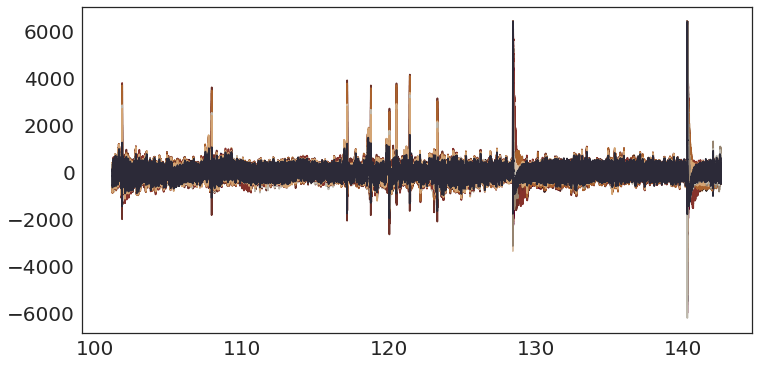

In [6]:
#plot! All 32 channels are plotted here overlaid
[npl.plot(tetrode) for tetrode in asa]

<br><div class="alert alert-warning">
All data loaded up. It is worth noting here that when the everything flag is set to True, data is returned as a Python list of AnalogSignalArrays. In the example below, only specific channels are requested not "everything" and that results in a singular AnalogSignalArray being returned consisting of signals from the specific channels that are requested. Once again, the signals will be labeled so they are discriminatable.
</div>

<br><div class="alert alert-info">
Quick example of how to load up particular channels from a .rec file. 
</div>

In [8]:
#Linux
#let's load tetrode 1 channels 1 and 4 and tetrode 3 channel 2!
asa = neltro.load_wideband_lfp_rec("/home/shayok/Documents/Code/RippleDetectionAnalysis/TingData/Kant_stimulation_two_channel14_5_27.rec",\
                      "/home/shayok/Documents/Code/trodes/", tetrode = [1,1,3], channel = [1,4,2])
asa

/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:267: UserWarning: creating support from time and sampling rate, fs!


<AnalogSignalArray at 0x7f914f4aa780: 3 signals> for a total of 1:21:996 minutes

In [3]:
#Windows
asa = neltro.load_wideband_lfp_rec("C:/Users/kemere_lab/Desktop/ShayWillDeleteThisFile/Kant_control_stimulation_single_channel1_5_27.rec",\
                      "C:/Users/kemere_lab/Documents/Code/trodes/", tetrode = [1,1,3], channel = [1,3,2])
asa

c:\users\kemere_lab\documents\code\nelpy\nelpy\core\_analogsignalarray.py:267: UserWarning: No support given. Creating support from time and sampling rate, fs!


<AnalogSignalArray at 0x21370509128: 3 signals> for a total of 41.442 seconds

C:\Users\kemere_lab\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['Universalis ADF Cd Std'] not found. Falling back to DejaVu Sans


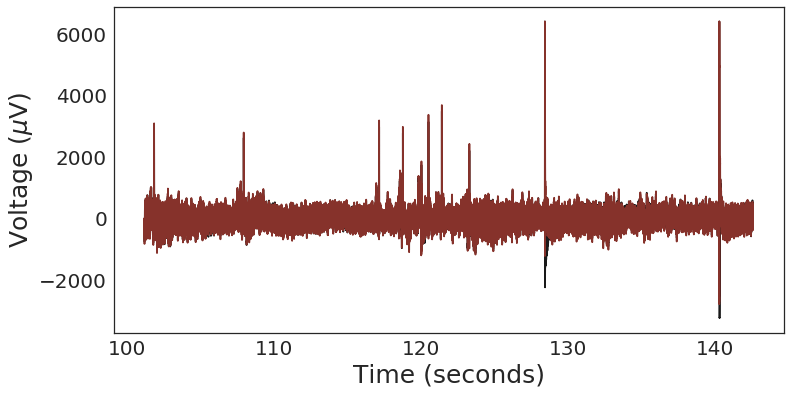

In [4]:
ax = npl.plot(asa)
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Voltage ($\mu$V)")

<br><div class="alert alert-info">
More fun example of how to load up particular channels and run a quick ripple detection algorithm on it :)
</div>

In [10]:
#let's load up tetrode 15 channels 1,2,3 and tetrode 17 channel 2
asa = neltro.load_wideband_lfp_rec("/media/shayok/3TBData/Data/JChuTru/Install/install_05-30-2017(12_07_13).rec",\
                      "/home/shayok/Documents/Code/trodes/", tetrode = [15,15,15,17],\
                      channel = [1,2,3,2], decimation_factor = 1, verbose = False)
asa

/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:267: UserWarning: creating support from time and sampling rate, fs!


<AnalogSignalArray at 0x7f914db4a6d8: 4 signals> for a total of 3:59:823 minutes

In [11]:
# filter raw data in ripple band
cows = nel.filtering.ripple_band_filter(asa, verbose=True)

# compute envelope of signal
cowy = nel.utils.signal_envelope1D(cows,)

Filtering with 100 taps.


In [12]:
#ripple detection across channels!
ripple_epochs = []
for i,cow in enumerate(cowy.signals):
    #find ripples!
    ripple_bounds, ripple_maxes, ripple_events = \
                                nel.utils.get_events_boundaries(cow.ydata, \
                                minThresholdLength = 0.015, ds=1/cow.fs)
    #ripple bounds stored as epoch arrays
    ripple_epochs.append(nel.EpochArray((ripple_bounds/cow.fs)+cow.time[0]))

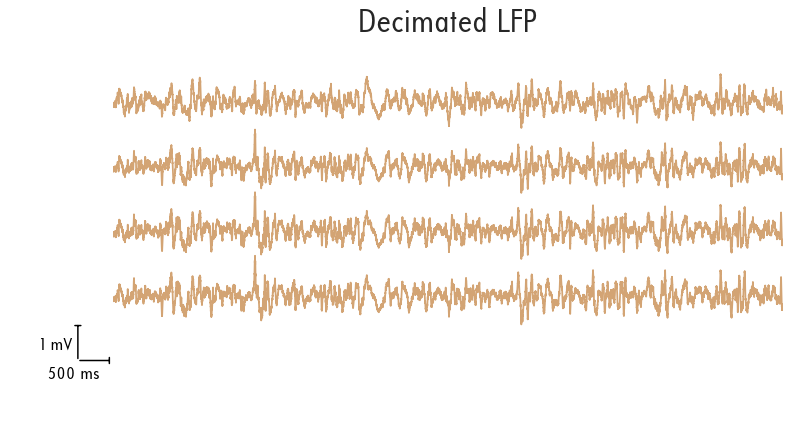

In [31]:
for i,cow in enumerate(asa.signals):
    #plot lfp
    ax = npl.plot(cow+1750*i,color=npl.colors.cows.jersey)
    #let's just look at a subset of the data
    ax.set_xlim(4500,4510)
    ax.set_title("Decimated LFP")

npl.utils.clear_left_right(ax)
npl.utils.clear_top_bottom(ax)

npl.scalebar.add_scalebar(ax=ax, sizex=0.5, sizey=1000, labely='1 mV', labelx='500 ms', pad=1.75, loc=3, bbox_to_anchor=(0,0))

/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


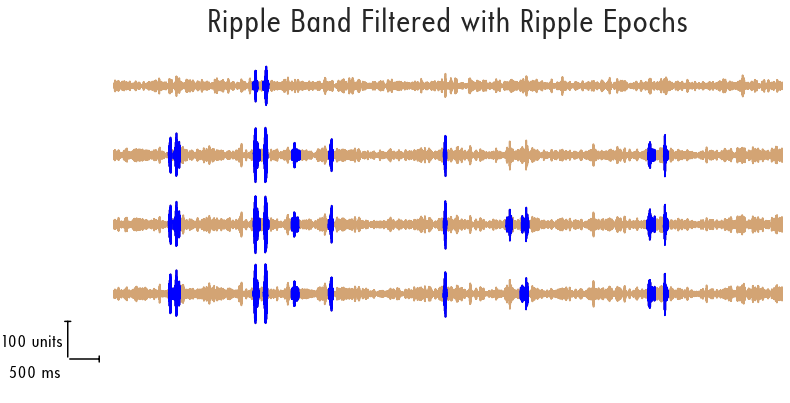

In [30]:
for i,cow in enumerate(cows.signals):
    #plot ripple band filtered data
    ax = npl.plot(cow+175*i,color=npl.colors.cows.jersey)
    #plot ripple episodes!
    npl.plot(cow[ripple_epochs[i]]+175*i,color = 'blue')
    #let's just look at a subset of the data
    ax.set_xlim(4500,4510)
    ax.set_title("Ripple Band Filtered with Ripple Epochs")
    
npl.utils.clear_left_right(ax)
npl.utils.clear_top_bottom(ax)

npl.scalebar.add_scalebar(ax=ax, sizex=0.5, sizey=100, labely='100 units', labelx='500 ms', pad=0, loc=3,bbox_to_anchor=(0,20))

/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


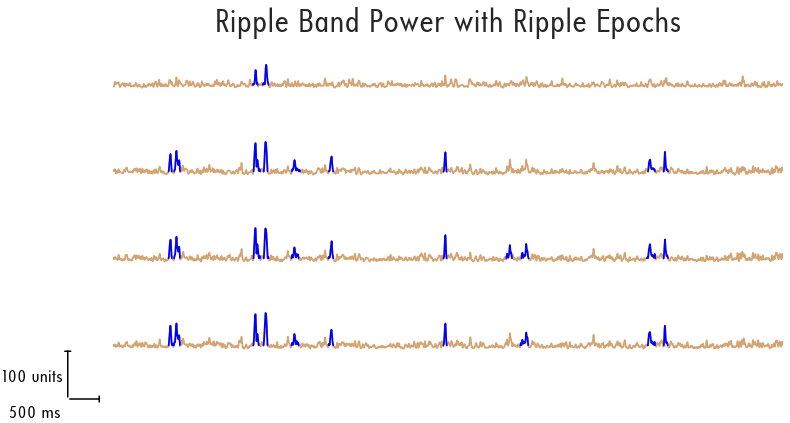

In [20]:
for i,cow in enumerate(cowy.signals):
    #plot lfp
    ax = npl.plot(cow+175*i,color=npl.colors.cows.jersey)
    #plot ripple episodes!
    npl.plot(cow[ripple_epochs[i]]+175*i,color = 'blue')
    #let's just look at a subset of the data
    ax.set_xlim(4500,4510)
    ax.set_title("Ripple Band Power with Ripple Epochs")
    
npl.utils.clear_left_right(ax)
npl.utils.clear_top_bottom(ax)

npl.scalebar.add_scalebar(ax=ax, sizex=0.5, sizey=100, labely='100 units', labelx='500 ms', pad=0, loc=3,bbox_to_anchor=(0,0))

<div class="alert alert-info">
Delete files after they've .dat files that are extracted after they've been imported into AnalogSignalArrays. This may be a useful thing to do if you're worried about memory and want to have minimalistic amount of things saved.
</div>

In [2]:
#let's load tetrode 1 channels 1 and 4 and tetrode 3 channel 2!
asa = neltro.load_wideband_lfp_rec("/home/shayok/Desktop/Kant_stimulation_5_24.rec",\
                      "/home/shayok/Documents/Code/trodes/", tetrode = [1,1,3], channel = [1,4,2], delete_files=True)
asa

/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:267: UserWarning: creating support from time and sampling rate, fs!


<AnalogSignalArray at 0x7fdc4033c748: 3 signals> for a total of 2:13:008 minutes

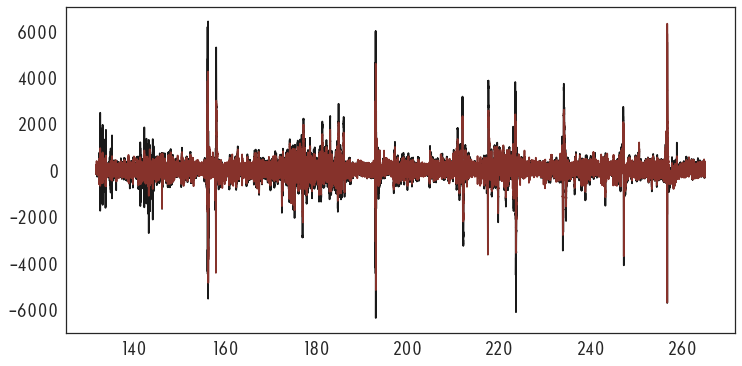

In [4]:
npl.plot(asa)

<div class="alert alert-success">
This pretty much sums up how to load up lfp data into .rec files for the most general usage for most people. There are two more examples below that are useful for those loading up large amounts of lfp data into nelpy from .rec files and for those doing real-time analysis using Trodes as a part  of a closed loop system (this example is after the DIO section).
</div>

<br><div class="alert alert-info">
Saving data that doesn't fit into your RAM...Personal recommendation is to save it in ASAs if possible and then only analyze chunks of it.<br><br>

In this example, we are going to load up all data from all tetrodes of a 20 tetrode drive....well a couple tetrodes aren't useful so we don't care about them and they will be disabled.
</div>

In [3]:
import gc #garbage collectors are of lower priority to run so they need to be explicitly triggered
          #or we'll run out of RAM
def saveData(tetrode,fname,savefname,*,alreadyextracted=False,verbose=True):
    """all channels for tetrode loaded up as ASA and use nelpy results container to pickle!
    """
    asa = neltro.load_wideband_lfp_rec(fname, "/home/shayok/Documents/Code/trodes/", tetrode = tetrode, \
                                       everything = True, data_already_extracted=alreadyextracted)
    res = nel.ResultsContainer(asa = asa).save_pkl(savefname.format(tetrode),zip=False,protocol=4)
    if verbose:
        print("Tetrode {} pickled!!".format(tetrode))
    gc.collect() #remove useless stuff prior to exiting function

In [4]:
fname = "/media/shayok/3TBData/Data/JChuTru/Install/Experiments/unthethered/07-03-2017/merged/install_07-03-2017_01_17_02_linear_track_merge_sd11.rec"
savefname = "/media/shayok/3TBData/Data/JChuTru/Install/Experiments/unthethered/07-03-2017/pickledData/LinearTrack/t{}.pkl"
tetrodes, _ = neltro.load_tetrode_channel_nums(fname,
                                               disable_tetrodes=[2,7,8,18])
tetrodes = np.unique(tetrodes) #only need each tetrode once....should be clear why we need to do this from above subsection examples
for i in tqdm(range(len(tetrodes))): #loop through and pickle all channels for each tetrode.
    if i: #let's not extract the same data more than once from the .rec
        saveData(tetrodes[i], fname, alreadyextracted=True, verbose=False) #doing this within a function so it's easier to remove stuff from RAM with the garbage collector
    else: 
        saveData(tetrodes[i], fname, savefname, alreadyextracted=False, verbose=False) #doing this within a function so it's easier to remove stuff from RAM with the garbage collector

Disabling Tetrode 2 
Disabling Tetrode 7 
Disabling Tetrode 8 
Disabling Tetrode 18 


/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:267: UserWarning: creating support from time and sampling rate, fs!


File "/media/shayok/3TBData/Data/JChuTru/Install/Experiments/unthethered/06-30-2017/pickledData/t1.pkl" already exists! Aborting...
Tetrode 1 pickled!!
File "/media/shayok/3TBData/Data/JChuTru/Install/Experiments/unthethered/06-30-2017/pickledData/t3.pkl" already exists! Aborting...
Tetrode 3 pickled!!
File "/media/shayok/3TBData/Data/JChuTru/Install/Experiments/unthethered/06-30-2017/pickledData/t4.pkl" already exists! Aborting...
Tetrode 4 pickled!!
File "/media/shayok/3TBData/Data/JChuTru/Install/Experiments/unthethered/06-30-2017/pickledData/t5.pkl" already exists! Aborting...
Tetrode 5 pickled!!
Tetrode 6 pickled!!
Tetrode 9 pickled!!
Tetrode 10 pickled!!
Tetrode 11 pickled!!
Tetrode 12 pickled!!
Tetrode 13 pickled!!
Tetrode 14 pickled!!
Tetrode 15 pickled!!
Tetrode 16 pickled!!
Tetrode 17 pickled!!
Tetrode 19 pickled!!
Tetrode 20 pickled!!


<br><div class="alert alert-success">
Very simply put, this is all there is on how to load up LFP data from Trodes .rec files into nelpy. For further information check the function calls and flags. See AnalogSignalArrayDemo (plotting.ipynb might also be a good example notebook to view but plots are included in the ASA demo notebook) for how to manipulate the data inside and what all you can do! Also, if you're planning to use the nelpy framework EpochArrayDemo is a must see/understand to be able to analyze particular epochs (e.g. stimulation periods, transient LFP events, etc...).
</div>

# Importing Digital Input Channels

## Get channels

In [2]:
#Linux
channels = neltro.load_digital_channel_nums("/home/shayok/Documents/Code/RippleDetectionAnalysis/TingData/Kant_control_stimulation_single_channel1_5_27.rec", verbose = True)

Channel in Array 1
Channel in Array 2
Channel in Array 3
Channel in Array 4
Channel in Array 5
Channel in Array 6
Channel in Array 7
Channel in Array 8


In [3]:
#Windows
channels = neltro.load_digital_channel_nums("C:/Users/kemere_lab/Desktop/ShayWillDeleteThisFile/Kant_control_stimulation_single_channel1_5_27.rec", verbose = True)

Channel in Array 1
Channel in Array 2
Channel in Array 3
Channel in Array 4
Channel in Array 5
Channel in Array 6
Channel in Array 7
Channel in Array 8


<div class="alert alert-success">
Very similar to importing LFP data
</div>

## Begin imports into numpy arrays <br>
<div class="alert alert-warning">
Note: This will be changed to EventArrays in the future (ETA: Unknown!)
</div>

In [3]:
#Linux
digital_in = neltro.load_dio_rec("/home/shayok/Documents/Code/RippleDetectionAnalysis/TingData/Kant_control_stimulation_single_channel1_5_27.rec","/home/shayok/Documents/Code/trodes/",channel=channels,data_already_extracted=False, verbose=False)

In [4]:
#Windows
digital_in = neltro.load_dio_rec("C:/Users/kemere_lab/Desktop/ShayWillDeleteThisFile/Kant_control_stimulation_single_channel1_5_27.rec","C:/Users/kemere_lab/Documents/Code/trodes/",channel=channels,data_already_extracted=False, verbose=False)

In [5]:
len(digital_in)

8

In [6]:
[print(x) for x in digital_in]

[(3034980, 0) (3054649, 1) (3054653, 0) (3237611, 1) (3237614, 0)
 (3514229, 1) (3514232, 0) (3562632, 1) (3562635, 0) (3600611, 1)
 (3600614, 0) (3614993, 1) (3614997, 0) (3642240, 1) (3642243, 0)
 (3698531, 1) (3698535, 0) (3859441, 1) (3859444, 0) (4061871, 1)
 (4061874, 0) (4209669, 1) (4209672, 0)]
[(3034980, 0)]
[(3034980, 0)]
[(3034980, 0)]
[(3034980, 0)]
[(3034980, 0)]
[(3034980, 0)]
[(3034980, 0)]


[None, None, None, None, None, None, None, None]

<div class="alert alert-info">
Okay so only Din1 has the stimulation data we need
</div>

In [7]:
tempy = digital_in[0] #temporary variable named tempy because pet names usually have a 'y' at the end?
#Timestamps of digital triggers
tempy['dio'][np.where(tempy['dio']>0)], tempy['time'][np.where(tempy['dio']>0)]

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8),
 array([3054649, 3237611, 3514229, 3562632, 3600611, 3614993, 3642240,
        3698531, 3859441, 4061871, 4209669], dtype=uint32))

<div class="alert alert-success">
Digital inputs have now been loaded into numpy arrays and can be used alongside LFP data.
</div>

# Importing Spike Data into `Nelpy`

<div class="alert alert-info">
It is worth noting that other spike extraction/sorting software may provide more comprehensive visualization than Trodes threshold crossing with lockout.<br><br>
In any case, the data is formatted as 40 data points around the threshold crossing with data from all 4 channels of the tetrode.
</div>

<div class="alert alert-danger">
There seems to be errors running this so I'm giving up. Also, I really don't think this is worth it. Maybe exporting Trodes data into MountainSort or other spike detection software is easier? It is definitely a lot more worthwhile. 
</div>

# Other Spike Detection Algorithm

In [ ]:
#NOTE: Etienne changed variable names!
def n_threshold(udder, moo, cow=None, T=None):
    """
    Find spikes in neural activity.
    
    TODO: make algorthm epoch-aware
    
    Parameters
    ==========
    udder : is of size KxN, where N is the number of channels of a multichannel udderset
    moo : is the mooeshold in the units of the udder (scalar, or size 1xN, Nx1, or N)
    cow : is the number of samples to include before mooeshold crossing
    T : is the number of samples to include in the waveform

    Returns
    =======
    
    cheese : M x T x N, where M is the number of cheeses, and N is the number of channels
    whey : list of length M, with cheese times in sample numbers
    
    """
    
    if cow is None:
        cow = 9
    if T is None:
        T = 40
        
    K, N = udder.shape
    
    try:
        if len(moo)==1:
            moo = np.ones((1,N)) * moo
    except TypeError:
        moo = np.ones((1,N)) * moo
    
    try:
        moo = np.reshape(moo, (1, N))
    except ValueError:
        raise ValueError("moo must either be a scalar, or an array-like with length {}".format(N))

    milk = T - cow - 1

    moo_udder = (udder > moo).sum(axis=1)
    ii = cow
    s = 0
    whey = []
    while ii < K - milk: # TODO: this is not yet epoch-aware
        if moo_udder[ii]:
            s = s + 1
            whey.append(ii)
            ii = ii + milk
        else:
            ii = ii + 1
    
    n_spikes = len(whey)
    cheese = np.zeros((n_spikes, T, N)) # M x 40 x 4 <==> M x T x N
    
    for ii, st in enumerate(whey):
        cheese[ii,:,:] = udder[st-cow:st+milk+1, :]
            
    return whey, cheese

# Importing Data for Real-Time Analysis

<div class="alert alert-info">
A few things must be done differently for real-time analysis of Trodes data. My particular experience doing this involves logging real-time LFP event detection to one of the Digital Input pins on the SpikeGadgets ECU and the OpenEphys FPGA. As such, I will go through how I did that just incase it is helpful to anyone else! <br><br>

As previously stated, exporting Trodes .rec files relies heavily on the modified versions of C++ export functions provided in the Trodes repository (under resources in the nelpy github repo). In general, if you're decimating (or subsampling) your data, it is recommended to use the subsample function provided within AnalogSignalArray class. Additionally, if you are filtering your data, it is recommended that you use the nelpy filter functions. However, for real-time analysis, we need to get virtually identical data to what modules communicating to Trodes would receive. For example, consider the [Ripple Detection Module](https://bitbucket.org/mkarlsso/trodes/src/ea50f3e9a633?at=rippleDetectionBeagleBoneStimModule). This module receives LFP data from Trodes which is (1) lowpass filtered at whatever frequency is specified within the config file (400 Hz if the KemereLab or SDModule config files are used) and (2) decimated by a factor of 1. Trodes itself uses an IIR filter to get LFP band signal to the modules and then "simple" decimation is done by sending every 10th sample to the Ripple Detection Module.
</div>

## Importing data from .rec with flags for Trodes filtering and decimation

In [2]:
real_time_signals = neltro.load_wideband_lfp_rec("/home/shayok/Documents/Code/RippleDetectionAnalysis/TingData/Kant_control_stimulation_single_channel1_5_27.rec",\
                      "/home/shayok/Documents/Code/trodes/", tetrode = [4,3],\
                      channel = [1,3], trodes_style_decimation=True, trodes_lowpass_filter_freq=400,\
                      trodes_highpass_filter_freq=-1, verbose = False)
real_time_signals

<AnalogSignalArray at 0x7fdad0260d30: 2 signals> for a total of 41.442 seconds

In [3]:
#subtract off reference and generate new analogsignal
real_time_signals.add_signal(real_time_signals.ydata[0]-real_time_signals.ydata[1],label="t4c1_LowpassFiltered_Decimated_RefSubtracted")

<AnalogSignalArray at 0x7fdad0260d30: 3 signals> for a total of 41.442 seconds

In [4]:
real_time_signals.labels

array(['t4c1', 't3c3', 't4c1_LowpassFiltered_Decimated_RefSubtracted'], 
      dtype='<U44')

In [13]:
scipy.io.savemat("/home/shayok/Desktop/Stimulation_singlechannel_control.mat",{'t4c1_filtered_decimated_refsubtracted':real_time_signals.ydata[-1].squeeze()})

In [5]:
%matplotlib notebook

<IPython.core.display.Javascript object>


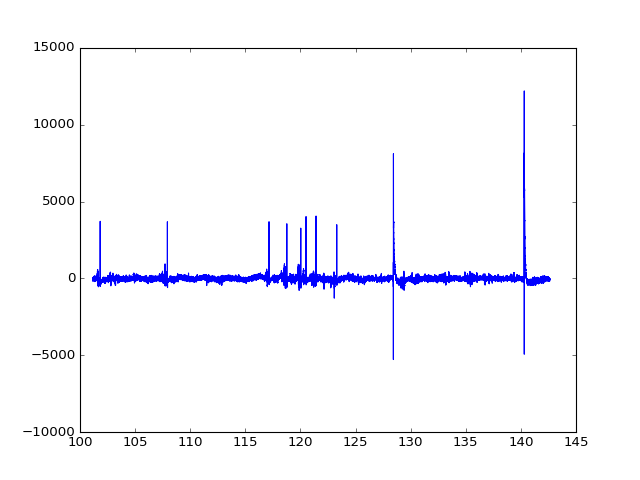

<AnalogSignalArray at 0x7fda91c9eb70: 1 signals> for a total of 41.442 seconds


In [6]:
npl.plot(real_time_signals[:,-1])
plt.show()

## Importing digital input data for log of event detection

In [5]:
#digital input channel 1 logged the detection pulses
digital_in = neltro.load_dio_rec("/home/shayok/Documents/Code/RippleDetectionAnalysis/TingData/Kant_control_stimulation_single_channel1_5_27.rec","/home/shayok/Documents/Code/trodes/",channel=[1],data_already_extracted=False, verbose=False)

In [6]:
digital_in

[array([(3034980, 0), (3054649, 1), (3054653, 0), (3237611, 1),
        (3237614, 0), (3514229, 1), (3514232, 0), (3562632, 1),
        (3562635, 0), (3600611, 1), (3600614, 0), (3614993, 1),
        (3614997, 0), (3642240, 1), (3642243, 0), (3698531, 1),
        (3698535, 0), (3859441, 1), (3859444, 0), (4061871, 1),
        (4061874, 0), (4209669, 1), (4209672, 0)], 
       dtype=[('time', '<u4'), ('dio', 'u1')])]

In [7]:
detection_times = digital_in[0]['time'][np.where(digital_in[0]['dio']>0)]
detection_times

array([3054649, 3237611, 3514229, 3562632, 3600611, 3614993, 3642240,
       3698531, 3859441, 4061871, 4209669], dtype=uint32)

<div class="alert alert-warning">
<b>These are NOT detection times these are actually the stimulation times. There was a 200 ms delay between detection and stimulation so I'm going to subtract off the delay to get detection times.</b>
</div>

In [74]:
stimulation_times = detection_times
detection_times = (stimulation_times/30000) - 0.2

## Importing data from .rec file with `nelpy` filtering and Trodes decimation. <br>
<div class="alert alert-info">
This data will be used to compare phase shifts caused by the real-time filters. So this way, we will be able to compare when events transpired versus when they were detected and delays introduced by real-time analysis (computational + hardware delays).
</div>

In [8]:
offline_analysis_signals = neltro.load_wideband_lfp_rec("/home/shayok/Documents/Code/RippleDetectionAnalysis/TingData/Kant_control_stimulation_single_channel1_5_27.rec",\
                      "/home/shayok/Documents/Code/trodes/", tetrode = [4,3],\
                      channel = [1,3], trodes_style_decimation=True, verbose = False)

/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:267: UserWarning: No support given. Creating support from time and sampling rate, fs!


In [9]:
#subtract off reference and generate new analogsignal
offline_analysis_signals.add_signal(offline_analysis_signals.ydata[0]-offline_analysis_signals.ydata[1],label="t4c1_refsubtracted")

<AnalogSignalArray at 0x7f8e840e66a0: 3 signals> for a total of 41.442 seconds

In [12]:
#add LFP (1-400 Hz)
offline_analysis_signals.add_signal(nel.filtering.bandpass_filter(offline_analysis_signals[:,2],lowcut=1,highcut=400,numtaps=\
                                                 nel.filtering.approx_number_of_taps(offline_analysis_signals.fs,15)),\
                                   label="t4c1_refsubtracted_lowpassfiltered")

/home/shayok/Documents/Code/nelpy/nelpy/filtering.py:105: UserWarning: no sampling frequency provided, using fs=30000.0 Hz from AnalogSignalArray


<AnalogSignalArray at 0x7f8e840e66a0: 4 signals> for a total of 41.442 seconds

## Example plots of data received and analyzed by real-time module vs data as it was logged by the data acquisition unit

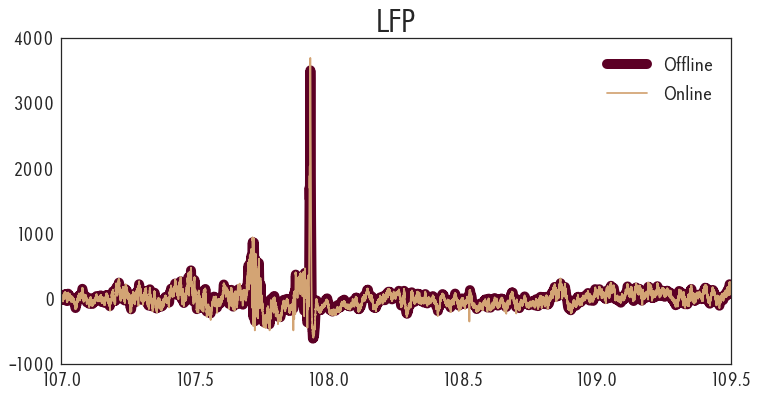

In [44]:
ax = npl.plot(offline_analysis_signals[:,-1],color=npl.colors.cows.texas_aggie,lw=10,label="Offline")
npl.plot(real_time_signals[:,-1],color=npl.colors.cows.jersey,label="Online")
ax.legend()
ax.set_xlim(107,109.5)
ax.set_ylim(-1000,4000)
ax.set_title("LFP")

## SWR event in above example and detection delay quantification example

<div class="alert alert-info">
In the example below we use an EpochArray of all ripples events and quantify delay by subtracting EpochArray start-time with the digital input pulse low-to-high state change timestamp.
</div>

In [45]:
#offline analysis
# filter raw data in ripple band (150 - 250 Hz)
ripple_band_filtered_offline = nel.filtering.ripple_band_filter(offline_analysis_signals[:,-1], verbose=True)

# compute envelope of signal (Hilbert Transform)
envelope_offline = nel.utils.signal_envelope1D(ripple_band_filtered_offline,)

Filtering with 1000 taps.


In [46]:
#ripple detection across channels!
ripple_epochs = []
for i,cow in enumerate(envelope_offline.signals):
    #find ripples! Ripple band power signal 3 sd above mean for 15 ms 
    ripple_bounds, ripple_maxes, ripple_events = \
                                nel.utils.get_events_boundaries(cow.ydata, \
                                minThresholdLength = 0.015, ds=1/cow.fs)
    #ripple bounds stored as epoch arrays
    ripple_epochs.append(nel.EpochArray((ripple_bounds/cow.fs)+cow.time[0]))

<div class="alert alert-info">
Offline detection time stamps are below...followed by online detection times
</div>

In [48]:
offline_analysis_signals.time[ripple_bounds]

array([[ 107.6749    ,  107.77023333],
       [ 107.85943333,  107.9459    ],
       [ 116.89466667,  116.984     ],
       [ 118.51433333,  118.6922    ],
       [ 119.77203333,  119.99986667],
       [ 120.48983333,  120.52446667],
       [ 121.13673333,  121.22133333],
       [ 121.39893333,  121.4323    ],
       [ 122.1097    ,  122.16883333],
       [ 123.036     ,  123.09783333],
       [ 128.41233333,  128.45783333],
       [ 135.32996667,  135.43293333],
       [ 140.28833333,  140.3306    ]])

In [75]:
detection_times

array([ 101.62163333,  107.72036667,  116.94096667,  118.5544    ,
        119.82036667,  120.29976667,  121.208     ,  123.08436667,
        128.44803333,  135.1957    ,  140.1223    ])

<div class="alert alert-info">
Let's do a quick comparison offline ripple bound to online detection for the event shown in the previous plot.
</div>

In [83]:
arrow = u'$\u2193$'

/home/shayok/anaconda3/lib/python3.5/site-packages/matplotlib/patches.py:120: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 


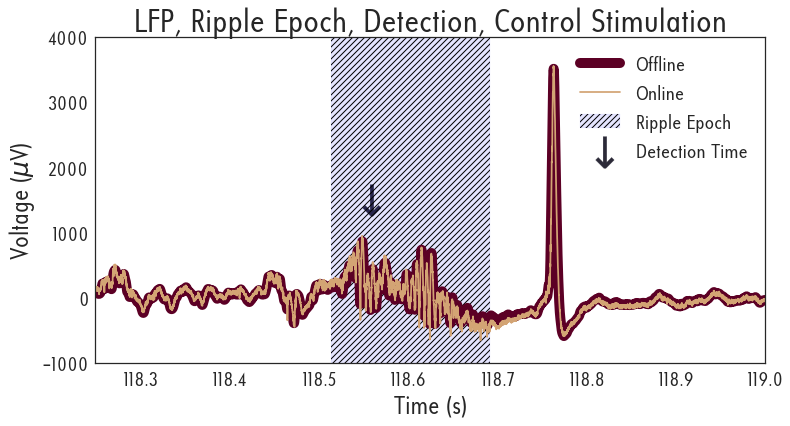

In [105]:
ax = npl.plot(offline_analysis_signals[:,-1],color=npl.colors.cows.texas_aggie,lw=10,label="Offline") #LFP offline
npl.plot(real_time_signals[:,-1],color=npl.colors.cows.jersey,label="Online") #LFP online 
npl.epochplot(nel.EpochArray([offline_analysis_signals.time[ripple_bounds]]),color='b',alpha=0.1, label="Ripple Epoch") #Canonical Ripple Epoch
ax.scatter(118.5544,1500,color=npl.colors.cows.angus,s=1000,marker=arrow,label="Detection Time") #detection timestamp
ax.legend()
ax.set_xlim(118.25,119)
ax.set_ylim(-1000,4000)
ax.set_title("LFP, Ripple Epoch, Detection, Control Stimulation")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage ($\mu$V)")

In [95]:
print("Detection Delay for Above Event: {} ms".format(np.round((118.5544-118.51433333)*1000,4)))

Detection Delay for Above Event: 40.0667 ms


# All of this is simple enough, right?
<div class="alert alert-danger">
WAIT! WHAT? I DON'T GET ANY OF THIS! WHAT DO I DO!?!?!?!
</div>
You can try to contact [Shayok](http://www.github.com/shayokdutta) he wrote this tutorial and should probably know what he's doing. In the situation that he doesn't, he'll be able to at the least point you to someone who knows what they are doing, most likely.